# Análise de dados e correlação de jogos eletrônicos

O intuito desse trabalho é analisar a relação de vários aspectos de jogos eletrônicos, entre eles duração, notas de usuários, data de lançamento, entre outros dados disponíveis em plataformas públicas a fim de estimar as tendências do mercado de games.

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcdefaults()
from IPython.display import set_matplotlib_formats

SyntaxError: invalid syntax (589318512.py, line 4)

## 1. Organização dos dados

Primeiro, é necessário limpar os dados e torná-los utilizáveis para análise

In [ ]:
data = []
with open('hltb.jsonlines') as lines:
    for line in lines:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df.head()

,Name,Stats,steam_app_id,Release_date,Genres,Review_score
0,Borderlands 3,{'Additional Content': {'Moxxi's Heist of the ...,397540,2019-09-13,"First-Person, Action, Shooter",76
1,Dying Light,{'Additional Content': {'The Following': {'Pol...,239140,2015-01-27,"Action, Adventure, Open World, Survival Horror",78
2,Middle-Earth: Shadow of War,{'Additional Content': {'Blade of Galadriel': ...,356190,2017-10-10,"Action, Adventure",76
3,Counter-Strike: Global Offensive,"{'Multi-Player': {'Co-Op': {'Polled': '34', 'A...",730,2012-08-21,"First-Person, Shooter",74
4,Grand Theft Auto IV,{'Additional Content': {'The Lost and Damned':...,5152,2008-04-29,"Third-Person, Action, Sandbox, Shooter",82


### Convertendo dicionários aninhados em um único dicionário para aproveitamento dos dados

In [ ]:
def convert(list_dicts):
    total_dict = {}
    for outer_key, inner_dict in list_dicts.items():
        for inner_key, nested_dict in inner_dict.items():
            for nested_key, value in nested_dict.items():
                new_key = f'{outer_key}_{inner_key}_{nested_key}'
                total_dict[new_key] = value
    return total_dict

In [ ]:
# Aplicar a função de conversão e manter apenas as chaves primárias
total = df.Stats.apply(lambda x: convert(x)).to_list()

# Manter apenas as chaves primárias para manter o dataset limpo
keys_keep = [
    'Single-Player_Main Story_Average', 'Single-Player_Main + Extras_Average', 'Single-Player_Completionist_Average', 'Single-Player_Main Story_Rushed', 'Single-Player_All PlayStyles_Average', 'Speedruns_Any%_Average', 'Multi-Player_Co-Op_Average', 'Multi-Player_Competitive_Average'
]

total_keep = []
for g in total:
    temp = {i: g.get(i, '') for i in keys_keep}
    total_keep.append(temp)


In [ ]:
df_colunas_uteis = pd.concat(
    [df.drop(columns= ['Stats', 'steam_app_id']), 
    pd.DataFrame(total_keep)], 
    axis = 1
)
df_colunas_uteis.head()

,Name,Release_date,Genres,Review_score,Single-Player_Main Story_Average,Single-Player_Main + Extras_Average,Single-Player_Completionist_Average,Single-Player_Main Story_Rushed,Single-Player_All PlayStyles_Average,Speedruns_Any%_Average,Multi-Player_Co-Op_Average,Multi-Player_Competitive_Average
0,Borderlands 3,2019-09-13,"First-Person, Action, Shooter",76,23h 17m,47h 3m,77h 27m,16h 57m,43h 24m,,43½ Hours,19½ Hours
1,Dying Light,2015-01-27,"Action, Adventure, Open World, Survival Horror",78,18h 10m,37h 10m,58h 34m,11h 59m,32h 9m,4h 11m 15s,31 Hours,99 Hours
2,Middle-Earth: Shadow of War,2017-10-10,"Action, Adventure",76,20h 47m,37h 1m,56h 30m,12h 11m,38h 30m,2h 50m 9s,,
3,Counter-Strike: Global Offensive,2012-08-21,"First-Person, Shooter",74,,,,,,,436 Hours,884 Hours
4,Grand Theft Auto IV,2008-04-29,"Third-Person, Action, Sandbox, Shooter",82,27h 37m,41h 24m,77h 4m,17h 50m,37h 48m,10h 40m 40s,120 Hours,25½ Hours


In [ ]:
# Função para converter nomes de colunas para snake_case
def to_snake_case(column_name):
    return column_name.lower().replace(' ', '_').replace('-', '_')

# Aplicar a função aos nomes das colunas do dataframe
df_colunas_uteis.columns = [to_snake_case(col) for col in df_colunas_uteis.columns]
# Exibir as primeiras linhas do dataframe final

# Update the keys_keep list to use snake_case names
keys_keep = [to_snake_case(key) for key in keys_keep]

def convert_time_to_float(time_str):
    if not isinstance(time_str, str):
        time_str = str(time_str)
    time_str = time_str.replace('½', '.5')
    hours, minutes, seconds = 0, 0, 0
    if 'Hours' in time_str or 'Hour' in time_str:
        time_str = time_str.replace('Hours', '')
        hours = float(time_str.replace('Hours', ''))
    if 'Min' in time_str:
        time_str = time_str.replace('Min', '')
    if 'h' in time_str:
        parts = time_str.split('h')
        hours = float(parts[0].strip()) if parts[0].strip() else 0
        time_str = parts[1] if len(parts) > 1 else ''
    if 'm' in time_str:
        parts = time_str.split('m')
        minutes = float(parts[0].strip()) if parts[0].strip() else 0
        time_str = parts[1] if len(parts) > 1 else ''
    if 's' in time_str:
        parts = time_str.split('s')
        seconds = float(parts[0].strip()) if parts[0].strip() else 0
    return hours + (minutes / 60) + (seconds / 3600)
    return float(time_str) if time_str else 0

# Apply the conversion function only to the columns that have time values
time_columns = [
    'single_player_main_story_average', 'single_player_main_+_extras_average', 
    'single_player_completionist_average', 'single_player_main_story_rushed', 
    'single_player_all_playstyles_average', 'speedruns_any%_average', 
    'multi_player_co_op_average', 'multi_player_competitive_average'
]

for col in time_columns:
    df_colunas_uteis[col] = df_colunas_uteis[col].apply(convert_time_to_float)

# Create a new dataframe from df_colunas_uteis
df_final = df_colunas_uteis.copy()

# Display the first few rows to verify
df_final.head()

,name,release_date,genres,review_score,single_player_main_story_average,single_player_main_+_extras_average,single_player_completionist_average,single_player_main_story_rushed,single_player_all_playstyles_average,speedruns_any%_average,multi_player_co_op_average,multi_player_competitive_average
0,Borderlands 3,2019-09-13,"First-Person, Action, Shooter",76,23.283333,47.050000,77.450000,16.950000,43.40,0.000000,43.5,19.5
1,Dying Light,2015-01-27,"Action, Adventure, Open World, Survival Horror",78,18.166667,37.166667,58.566667,11.983333,32.15,4.187500,31.0,99.0
2,Middle-Earth: Shadow of War,2017-10-10,"Action, Adventure",76,20.783333,37.016667,56.500000,12.183333,38.50,2.835833,0.0,0.0
3,Counter-Strike: Global Offensive,2012-08-21,"First-Person, Shooter",74,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,436.0,884.0
4,Grand Theft Auto IV,2008-04-29,"Third-Person, Action, Sandbox, Shooter",82,27.616667,41.400000,77.066667,17.833333,37.80,10.677778,120.0,25.5


## Análise e correlação

Com os dados limpos, podemos analisá-los sem muitas dificuldades

---

### Gráficos 1: Média de tempo de Campanha Singleplayer ao longo dos anos

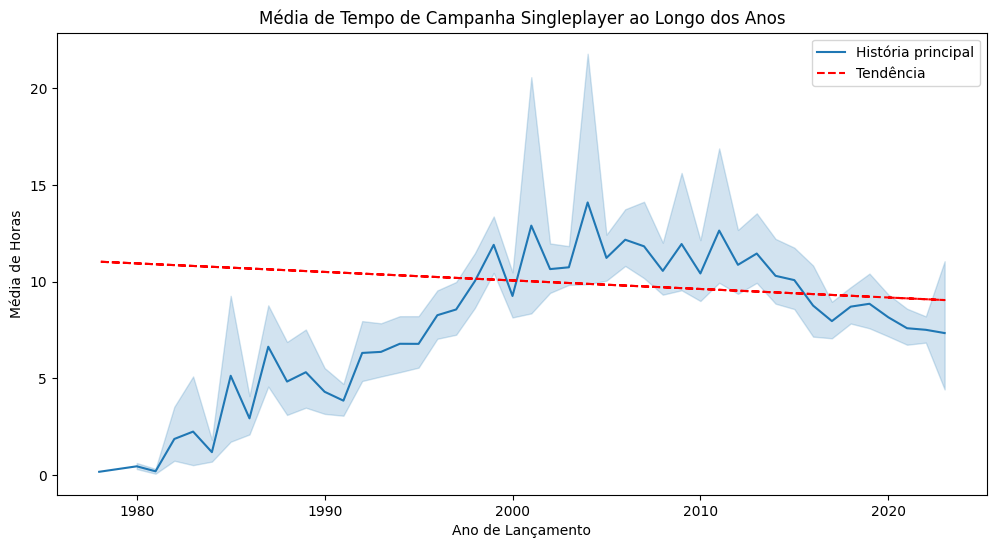

In [564]:
# Converter a coluna 'release_date' para datetime
df_final['release_date'] = pd.to_datetime(df_final['release_date'], errors='coerce')
# Filtrar os dados para remover valores nulos e valores zerados
df_filtered_single_main = df_final[(df_final['release_date'].notna()) & (df_final['single_player_main_story_average'] > 0)]
# Gerar o gráfico
plt.figure(figsize=(12, 6))
sb.lineplot(data=df_filtered_single_main, x=df_final['release_date'].dt.year, y='single_player_main_story_average', label='História principal')

# Adicionar a linha de tendência
z = np.polyfit(df_filtered_single_main['release_date'].dt.year, df_filtered_single_main['single_player_main_story_average'], 1)
p = np.poly1d(z)
plt.plot(df_filtered_single_main['release_date'].dt.year, p(df_filtered_single_main['release_date'].dt.year), linestyle='--', color='red', label='Tendência')

plt.title('Média de Tempo de Campanha Singleplayer ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Média de Horas')
plt.legend()
plt.show()

O crescimento da campanha média, que foi impulsionado pela terceira geração de consoles e a "Revolução 3D", devido ao aumento repentino da capacidade de processamento e memória dos dispositivos, estagnou na sétima geração, após a era do PS3 e do XBOX 360, demonstrando uma tendência de queda após os anos 2010. Esses dados evidendciam uma mudança drástica na indústria que têm se provado o futuro em entretenimento nos games. Veremos isso com mais clareza nos próximos gráficos.

---

### Gráfico 2: Tempo total de jogo médio por jogador em jogos Multiplayer ao Longo dos Anos

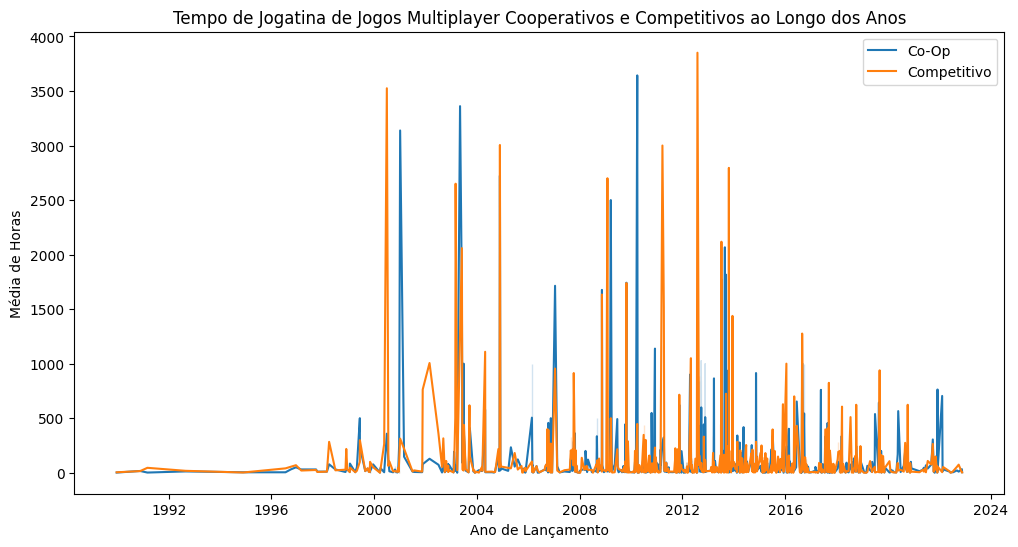

In [540]:
# Filtrar os dados para remover valores nulos e valores zerados
df_filtered_coop = df_final[(df_final['release_date'].notna()) & 
								    (df_final['multi_player_co_op_average'] > 0)]
df_filtered_comp = df_final[(df_final['release_date'].notna()) &  
									(df_final['multi_player_competitive_average'] > 0)]

# Gerar o gráfico
plt.figure(figsize=(12, 6))
sb.lineplot(data=df_filtered_coop, x='release_date', y='multi_player_co_op_average', label='Co-Op')
sb.lineplot(data=df_filtered_comp, x='release_date', y='multi_player_competitive_average', label='Competitivo')
plt.title('Tempo de Jogatina de Jogos Multiplayer Cooperativos e Competitivos ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Média de Horas')
plt.legend()
plt.show()

Esse gráfico, de forma bem sucinta, foi um erro da nossa parte. Não um erro de lógica, mas um erro de interpretação. Queríamos um gráfico que nos mostrasse o crescimento do tempo de jogo médio ao longo dos anos, mas ao deixarmos os casos extremos, acabamos com dados que nos mostram outra informação. É bem claro que alguns jogos dominam o mercado. Podemos ver que, após 2016, pouquíssimos jogos têm a mesma quantidade de horas médias por jogador. Levando isso em conta, mas não esquecendo o fato de que o tempo médio de jogo total é completamente dependente de há quanto tempo o jogo está no mercado, podemos mesmo assim afirmar que jogos anteriores a esse período dominam o mercado multijogador. Condizente a isso, podemos observar jogos como League of Legends (2009), Counter Strike: Global Offensive (2012) e Minecraft (2009) mantendo suas posições de jogos mais influentes do mundo ano após ano.

---

### Gráfico 3: Gráfico de tempo de jogo médio em jogos multiplayer consertado

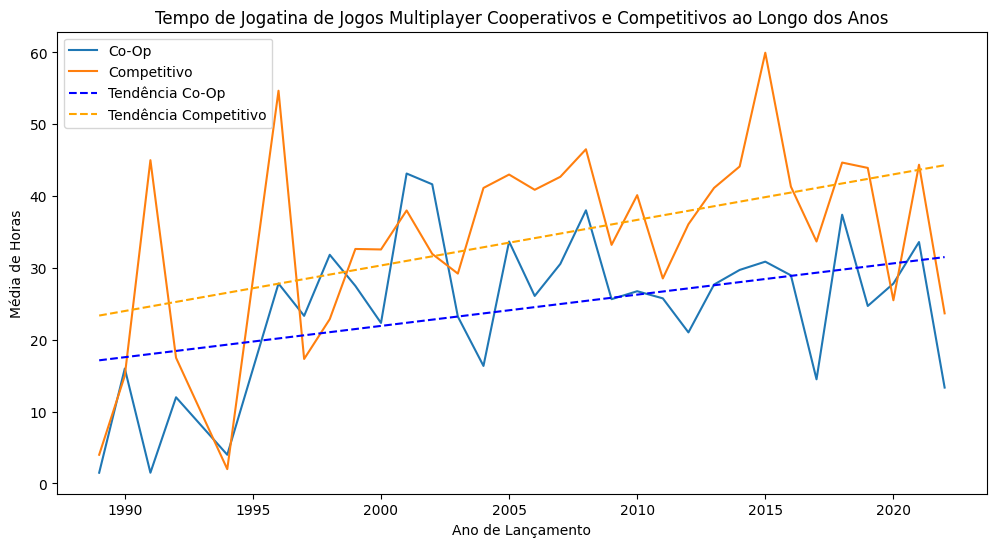

In [541]:
# Filtrar os dados para remover valores nulos e valores zerados
df_filtered_coop = df_final[(df_final['release_date'].notna()) & 
								    (df_final['multi_player_co_op_average'] > 0)]
df_filtered_comp = df_final[(df_final['release_date'].notna()) &  
									(df_final['multi_player_competitive_average'] > 0)]

# Excluir valores extremos
q1_coop = df_filtered_coop['multi_player_co_op_average'].quantile(0.25)
q3_coop = df_filtered_coop['multi_player_co_op_average'].quantile(0.75)
iqr_coop = q3_coop - q1_coop
lower_bound_coop = q1_coop - 1.5 * iqr_coop
upper_bound_coop = q3_coop + 1.5 * iqr_coop
df_filtered_coop = df_filtered_coop[(df_filtered_coop['multi_player_co_op_average'] >= lower_bound_coop) & (df_filtered_coop['multi_player_co_op_average'] <= upper_bound_coop)]

q1_comp = df_filtered_comp['multi_player_competitive_average'].quantile(0.25)
q3_comp = df_filtered_comp['multi_player_competitive_average'].quantile(0.75)
iqr_comp = q3_comp - q1_comp
lower_bound_comp = q1_comp - 1.5 * iqr_comp
upper_bound_comp = q3_comp + 1.5 * iqr_comp
df_filtered_comp = df_filtered_comp[(df_filtered_comp['multi_player_competitive_average'] >= lower_bound_comp) & (df_filtered_comp['multi_player_competitive_average'] <= upper_bound_comp)]

# Agrupar por ano e calcular a média
df_filtered_coop['year'] = df_filtered_coop['release_date'].dt.year
df_filtered_comp['year'] = df_filtered_comp['release_date'].dt.year

df_grouped_coop = df_filtered_coop.groupby('year')['multi_player_co_op_average'].mean().reset_index()
df_grouped_comp = df_filtered_comp.groupby('year')['multi_player_competitive_average'].mean().reset_index()

# Mesclar os dados agrupados de coop e comp
df_grouped = pd.merge(df_grouped_coop, df_grouped_comp, on='year', how='outer').sort_values(by='year')

# Gerar o gráfico
plt.figure(figsize=(12, 6))
sb.lineplot(data=df_grouped, x='year', y='multi_player_co_op_average', label='Co-Op')
sb.lineplot(data=df_grouped, x='year', y='multi_player_competitive_average', label='Competitivo')

# Adicionar a linha de tendência para Co-Op
z_coop = np.polyfit(df_grouped['year'], df_grouped['multi_player_co_op_average'], 1)
p_coop = np.poly1d(z_coop)
plt.plot(df_grouped['year'], p_coop(df_grouped['year']), linestyle='--', color='blue', label='Tendência Co-Op')

# Adicionar a linha de tendência para Competitivo
z_comp = np.polyfit(df_grouped['year'], df_grouped['multi_player_competitive_average'], 1)
p_comp = np.poly1d(z_comp)
plt.plot(df_grouped['year'], p_comp(df_grouped['year']), linestyle='--', color='orange', label='Tendência Competitivo')

plt.title('Tempo de Jogatina de Jogos Multiplayer Cooperativos e Competitivos ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Média de Horas')
plt.legend()
plt.show()


Ao excluirmos os casos extremos e calcularmos a média de cada ano, obtemos uma melhor noção das tendências e podemos fazer uma análise mais próxima da realidade. Não surpreendentemente, a indústria multiplayer vem crescendo, principalmente a de jogos competitivos. Vemos que a média teve picos em anos específicos, nos quais temos algumas coincidências. Em 1991, o boom dos arcades acontecia, e jogos multiplayer como Street Fighter 2 e Mortal Kombat monopolizavam o mercado. Em 1996, o Nintendo 64 foi lançado, console que marcou época com seus clássicos 3D. Somado à tendência de queda do Gráfico 1, podemos interpretar que os jogos multijogador e online têm roubado a presença dos jogos singleplayer e estão cada vez mais conquistando espaço no mercado mundial. Isso vai de encontro ao relato de muitos jogadores, que apreciam mais uma experiência que não necessite de muito tempo, pois jogos com longas campanhas são difíceis de terminar quando se trabalha o dia todo.

---

### Gráficos 4, 5 e 6: Correlação entre duração de jogos e notas dos usuários

In [542]:
def convert(list_dicts):
    total_dict = {}
    for outer_key, inner_dict in list_dicts.items():
        for inner_key, nested_dict in inner_dict.items():
            for nested_key, value in nested_dict.items():
                new_key = f'{outer_key}_{inner_key}_{nested_key}'
                total_dict[new_key] = value
    return total_dict

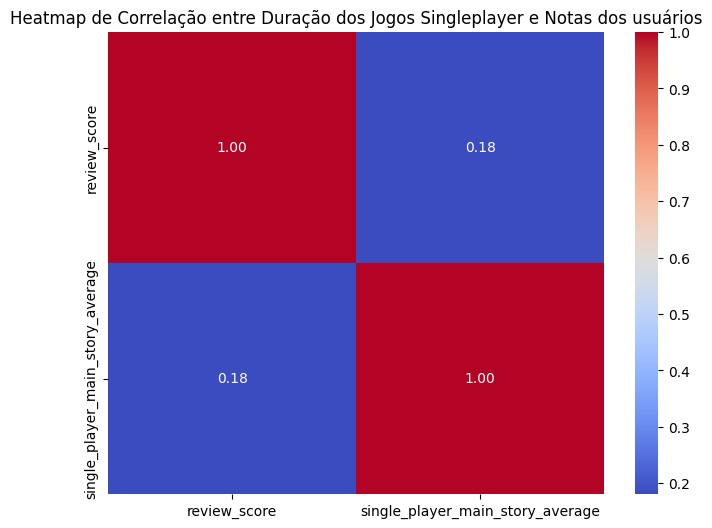

In [543]:
# Selecionar as colunas de interesse para a correlação
columns_of_interest = ['review_score', 'single_player_main_story_average']

# Filtrar colunas que não são numéricas
df_corr = df_final[columns_of_interest].select_dtypes(include=[np.number])

# Filtrar os jogos que tiverem a coluna single_player_main_story_average zerada ou fora do padrão
df_corr = df_corr[df_corr['single_player_main_story_average'] > 0]

# Normalizar os dados
df_corr = (df_corr - df_corr.mean()) / df_corr.std()

# Filtrar o dataframe para manter apenas as colunas de interesse
df_corr = df_final[columns_of_interest]

# Calcular a correlação
correlation_matrix = df_corr.corr()

# Gerar o heatmap
plt.figure(figsize=(8, 6))
heatmap = sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação entre Duração dos Jogos Singleplayer e Notas dos usuários')
plt.show()

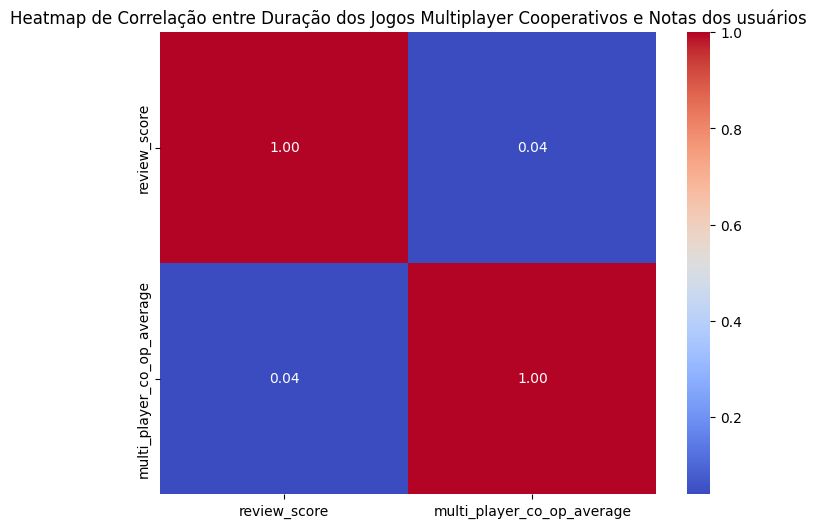

In [549]:
# Selecionar as colunas de interesse para a correlação
columns_of_interest = ['review_score', 'multi_player_co_op_average']

# Filtrar colunas que não são numéricas
df_corr = df_final[columns_of_interest].select_dtypes(include=[np.number])

# Filtrar os jogos que tiverem a coluna single_player_main_story_average zerada ou fora do padrão
df_corr = df_corr[df_corr['multi_player_co_op_average'] > 0]

# Normalizar os dados
df_corr = (df_corr - df_corr.mean()) / df_corr.std()

# Filtrar o dataframe para manter apenas as colunas de interesse
df_corr = df_final[columns_of_interest]

# Calcular a correlação
correlation_matrix = df_corr.corr()

# Gerar o heatmap
plt.figure(figsize=(8, 6))
heatmap = sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação entre Duração dos Jogos Multiplayer Cooperativos e Notas dos usuários')
plt.show()

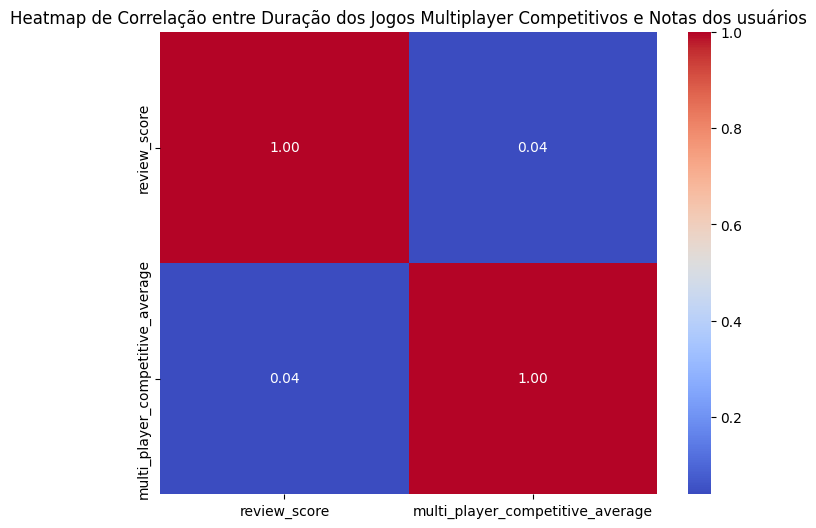

In [550]:
# Selecionar as colunas de interesse para a correlação
columns_of_interest = ['review_score', 'multi_player_competitive_average']

# Filtrar colunas que não são numéricas
df_corr = df_final[columns_of_interest].select_dtypes(include=[np.number])

# Filtrar os jogos que tiverem a coluna single_player_main_story_average zerada ou fora do padrão
df_corr = df_corr[df_corr['multi_player_competitive_average'] > 0]

# Normalizar os dados
df_corr = (df_corr - df_corr.mean()) / df_corr.std()

# Filtrar o dataframe para manter apenas as colunas de interesse
df_corr = df_final[columns_of_interest]

# Calcular a correlação
correlation_matrix = df_corr.corr()

# Gerar o heatmap
plt.figure(figsize=(8, 6))
heatmap = sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação entre Duração dos Jogos Multiplayer Competitivos e Notas dos usuários')
plt.show()

Não obtivemos sucesso ao determinar que as notas de usuários e as durações dos jogos estão correlacionadas de qualquer maneira, mas obtivemos uma correlação contrária, ao que tudo indica, a duração em si dos jogos não tende a influenciar diretamente nos resultados das notas dos usuários, visto que muitas variáveis estão envolvidas no processo de avaliar um jogo e pessoas possuem gostos diversificados.

---

### Gráfico X: Ano de lançamento X Notas de usuaŕios

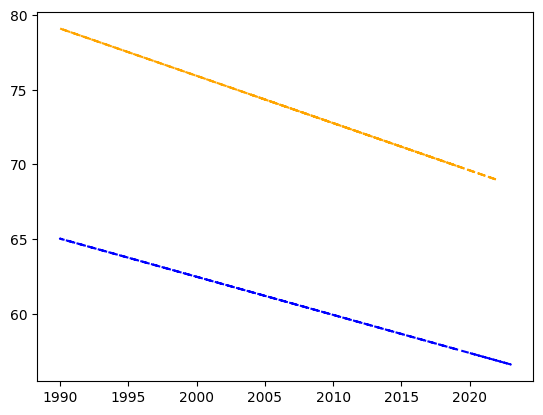

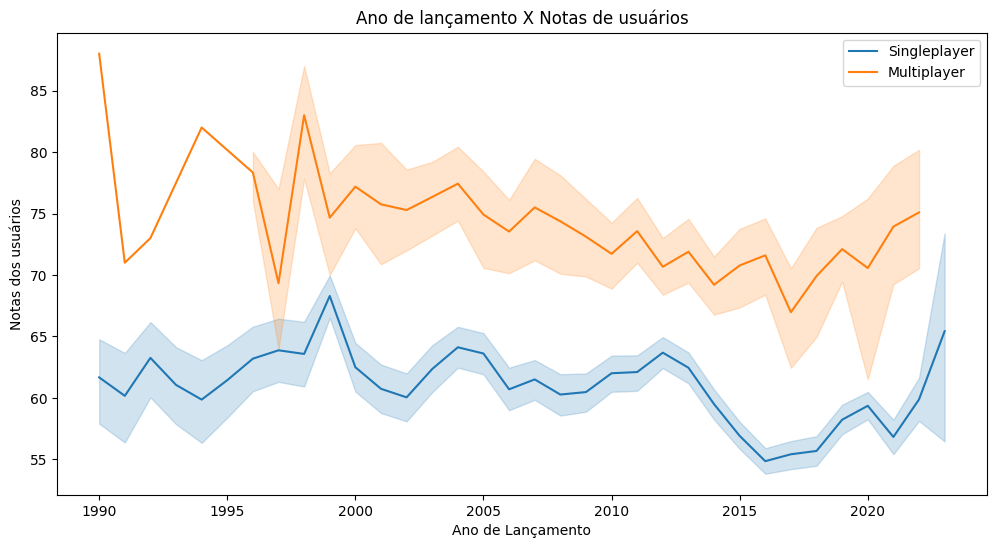

In [571]:
# Filtrar os dados para remover valores nulos e valores zerados
# df_filtered_geral = df_final[(df_final['release_date'].notna()) & (df_final['release_date'].dt.year > 1989) & ((df_final['single_player_main_story_average'] > 0) | (df_final['multi_player_co_op_average'] > 0) | (df_final['multi_player_competitive_average'] > 0))]
df_filtered_single = df_final[(df_final['release_date'].notna()) & (df_final['release_date'].dt.year > 1989) &
									(df_final['single_player_main_story_average'] > 0)]

df_filtered_multi = df_final[(df_final['release_date'].notna()) & (df_final['release_date'].dt.year > 1989) & 
									((df_final['multi_player_co_op_average'] > 0)|(df_final['multi_player_competitive_average'] > 0))]

# Adicionar a linha de tendência para Singleplayer
z_single = np.polyfit(df_filtered_single['release_date'].dt.year, df_filtered_single['review_score'], 1)
p_single = np.poly1d(z_single)
plt.plot(df_filtered_single['release_date'].dt.year, p_single(df_filtered_single['release_date'].dt.year), linestyle='--', color='blue', label='Tendência Singleplayer')

# Adicionar a linha de tendência para Multiplayer
z_multi = np.polyfit(df_filtered_multi['release_date'].dt.year, df_filtered_multi['review_score'], 1)
p_multi = np.poly1d(z_multi)
plt.plot(df_filtered_multi['release_date'].dt.year, p_multi(df_filtered_multi['release_date'].dt.year), linestyle='--', color='orange', label='Tendência Multiplayer')

# Gerar o gráfico
plt.figure(figsize=(12, 6))
# sb.lineplot(data=df_filtered_geral, x=df_final['release_date'].dt.year, y='review_score', label='Geral')
sb.lineplot(data=df_filtered_single, x=df_final['release_date'].dt.year, y='review_score', label='Singleplayer')
sb.lineplot(data=df_filtered_multi, x=df_final['release_date'].dt.year, y='review_score', label='Multiplayer')
plt.title('Ano de lançamento X Notas de usuários')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Notas dos usuários')
plt.legend()
plt.show()

Por fim, podemos analisar as notas dos usuários para jogos e organizá-las por data de lançamento. Devemos reiterar que essa não é uma análise cronológica de avaliações, e simplesmente uma categorização ordenada por ano.

Os dados do gráfico são interessantes, podemos, em primeira instância, observar queda repentina de notas a partir di ano 2012 para os jogos singleplayer. Além disso temos

Seguido disso, temos uma queda nas tendências